In [ ]:
!pip install torchmetrics

In [1]:
import csv
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchmetrics
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor

In [2]:
def eval_model(batch_no, loaded_model, dataset):
    rows = 4
    cols = 8
    start = rows * cols * batch_no
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i in range(rows * cols):
        idx = i + start
        j = i // cols
        k = i % cols
        axes[j][k].imshow(dataset.test_data[idx], cmap="gray")

        axes[j][k].tick_params(
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            left=False,
            labelbottom=False,
            labelleft=False,
        )
        with torch.no_grad():
            normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[idx][0]))
            prediction = loaded_model(normalized.unsqueeze(0)).argmax()
        pred_num = prediction.item()
        labl_num = dataset.targets[idx].item()
        title = f"{pred_num}-{labl_num}"
        border_color = "green" if pred_num == labl_num else "red"
        plt.setp(axes[j][k].spines.values(), lw=5, color=border_color, alpha=0.9)
        axes[j][k].set_title(title)


# Train model

## Train model with pytorch

In [4]:
from trainloop import train_loop_torch
from trainloop import build_resnet18
from trainloop import load_model_torch
from trainloop import build_data_loader_torch
from trainloop import report_metrics_torch
from trainloop import save_checkpoint_and_metrics_torch

2025-03-08 16:01:19,693	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Launch the training loop

In [4]:
timestamp = datetime.datetime.now(datetime.UTC).strftime("%Y-%m-%d_%H-%M-%S")
local_path = f"/tmp/ray/torch_{timestamp}"
train_loop_torch(num_epochs=4, local_path=local_path)

{'loss': 0.2948448359966278, 'epoch': 0, 'accuracy': 0.7934361696243286}
{'loss': 0.09106287360191345, 'epoch': 1, 'accuracy': 0.9477664232254028}
{'loss': 0.05585106834769249, 'epoch': 2, 'accuracy': 0.9681657552719116}
{'loss': 0.07025408744812012, 'epoch': 3, 'accuracy': 0.9799846410751343}


### Evaluate Trained Model

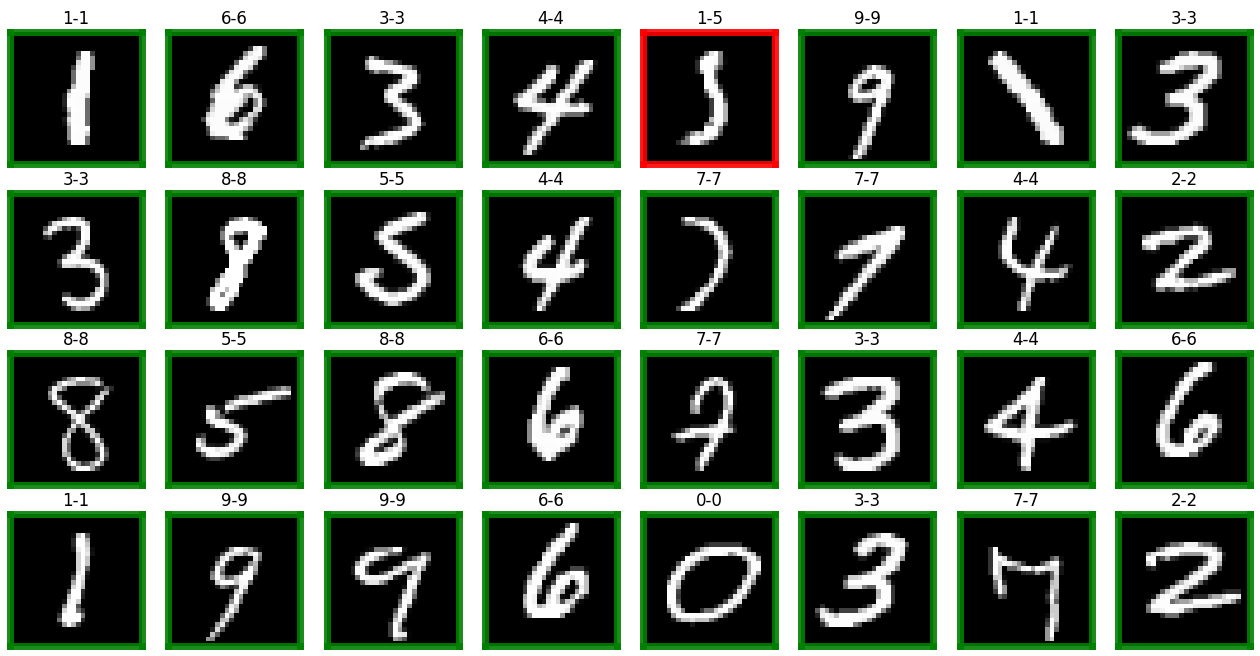

In [32]:
ckpt_dir = "/tmp/ray/torch_2025-03-05_23-28-05"
model_path = os.path.join(ckpt_dir, "model.pt")
loaded_model = build_resnet18()
state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()
dataset = MNIST(root="./data", train=True, download=True)

batch_no = 4

eval_model(batch_no, loaded_model, dataset)

## Train model with ray train

In [3]:
from trainloop import train_loop_ray_train
from trainloop import load_model_ray_train
from trainloop import build_data_loader_ray_train
from trainloop import build_resnet18
from trainloop import get_mnist_dataset
from trainloop import report_metrics_ray_train
from trainloop import save_checkpoint_and_metrics_ray_train

In [4]:
from ray.tune import RunConfig
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer

n_workers = 4 if not torch.cuda.is_available() else torch.cuda.device_count()
storage_path = "/tmp/ray_train"
run_config = RunConfig(storage_path=storage_path, name="distributed-mnist-resnet18")
scaling_config = ScalingConfig(num_workers=n_workers, use_gpu=torch.cuda.is_available())

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 10, "global_batch_size": 128},
)

result = trainer.fit()

2025-03-08 22:26:06,630	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-08 22:26:07,096	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `<FrameworkTrainer>(...)`.
2025-03-08 22:26:07,101	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-03-08 22:26:07 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 PENDING)




(TorchTrainer pid=68701) Started distributed worker processes: 
(TorchTrainer pid=68701) - (node_id=522c93c52a334f30ca8f3a33509e648a08f7c62346c5ed009bc42a93, ip=192.168.31.101, pid=68783) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=68783) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=68783) Moving model to device: cuda:0


== Status ==
Current time: 2025-03-08 22:26:12 (running for 00:00:05.19)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000000)


(RayTrainWorker pid=68783) {'loss': 0.23772941529750824, 'accuracy': 0.7955729365348816, 'auroc': 0.9736288189888}
== Status ==
Current time: 2025-03-08 22:26:17 (running for 00:00:10.24)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:26:22 (running for 00:00:15.25)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000001)


(RayTrainWorker pid=68783) {'loss': 0.1419582962989807, 'accuracy': 0.9473657608032227, 'auroc': 0.9893165826797485}
== Status ==
Current time: 2025-03-08 22:26:27 (running for 00:00:20.27)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000002)


(RayTrainWorker pid=68783) {'loss': 0.09688340872526169, 'accuracy': 0.9675981402397156, 'auroc': 0.9939277768135071}
== Status ==
Current time: 2025-03-08 22:26:32 (running for 00:00:25.30)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:26:37 (running for 00:00:30.31)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:26:42 (running for 00:00:35.32)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 acc

(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000003)


(RayTrainWorker pid=68783) {'loss': 0.027132732793688774, 'accuracy': 0.9796841740608215, 'auroc': 0.99605792760849}
== Status ==
Current time: 2025-03-08 22:26:47 (running for 00:00:40.39)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:26:52 (running for 00:00:45.40)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000004)


(RayTrainWorker pid=68783) {'loss': 0.08062200248241425, 'accuracy': 0.9874966740608215, 'auroc': 0.9972404837608337}
== Status ==
Current time: 2025-03-08 22:26:57 (running for 00:00:50.46)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:02 (running for 00:00:55.47)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:07 (running for 00:01:00.48)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 acc

(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000005)


(RayTrainWorker pid=68783) {'loss': 0.03792715072631836, 'accuracy': 0.9927884340286255, 'auroc': 0.9979756474494934}
== Status ==
Current time: 2025-03-08 22:27:12 (running for 00:01:05.49)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:17 (running for 00:01:10.50)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:22 (running for 00:01:15.51)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 acc

(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000006)


(RayTrainWorker pid=68783) {'loss': 0.0116620734333992, 'accuracy': 0.9959769248962402, 'auroc': 0.998461902141571}
== Status ==
Current time: 2025-03-08 22:27:32 (running for 00:01:25.54)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:37 (running for 00:01:30.55)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:42 (running for 00:01:35.56)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accel

(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000007)


== Status ==
Current time: 2025-03-08 22:27:47 (running for 00:01:40.60)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:52 (running for 00:01:45.61)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:27:57 (running for 00:01:50.63)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distri

(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000008)


(RayTrainWorker pid=68783) {'loss': 0.008890029042959213, 'accuracy': 0.9992654919624329, 'auroc': 0.9990388751029968}
== Status ==
Current time: 2025-03-08 22:28:12 (running for 00:02:05.69)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:28:17 (running for 00:02:10.71)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 22:28:22 (running for 00:02:15.72)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 ac

(RayTrainWorker pid=68783) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_5d3a3_00000_0_2025-03-08_22-26-07/checkpoint_000009)


== Status ==
Current time: 2025-03-08 22:28:32 (running for 00:02:25.76)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




2025-03-08 22:28:33,422	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/tmp/ray_train/distributed-mnist-resnet18' in 0.0022s.
2025-03-08 22:28:33,424	INFO tune.py:1041 -- Total run time: 146.32 seconds (146.29 seconds for the tuning loop).


== Status ==
Current time: 2025-03-08 22:28:33 (running for 00:02:26.29)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/32 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-03-08_22-26-06_091926_66482/artifacts/2025-03-08_22-26-07/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [5]:
result.metrics_dataframe

,loss,accuracy,auroc,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/num_epochs,config/train_loop_config/global_batch_size
0,0.237729,0.795573,0.973629,1741425976,checkpoint_000000,True,False,1,5d3a3_00000,2025-03-08_22-26-16,7.542814,7.542814,68701,euclid,192.168.31.101,7.542814,1,10,128
1,0.141958,0.947366,0.989317,1741425983,checkpoint_000001,True,False,2,5d3a3_00000,2025-03-08_22-26-23,6.922788,14.465602,68701,euclid,192.168.31.101,14.465602,2,10,128
2,0.096883,0.967598,0.993928,1741425992,checkpoint_000002,True,False,3,5d3a3_00000,2025-03-08_22-26-32,8.840782,23.306384,68701,euclid,192.168.31.101,23.306384,3,10,128
3,0.027133,0.979684,0.996058,1741426003,checkpoint_000003,True,False,4,5d3a3_00000,2025-03-08_22-26-43,10.776879,34.083263,68701,euclid,192.168.31.101,34.083263,4,10,128
4,0.080622,0.987497,0.997240,1741426015,checkpoint_000004,True,False,5,5d3a3_00000,2025-03-08_22-26-55,12.873472,46.956735,68701,euclid,192.168.31.101,46.956735,5,10,128
5,0.037927,0.992788,0.997976,1741426031,checkpoint_000005,True,False,6,5d3a3_00000,2025-03-08_22-27-11,15.028568,61.985303,68701,euclid,192.168.31.101,61.985303,6,10,128
6,0.011662,0.995977,0.998462,1741426048,checkpoint_000006,True,False,7,5d3a3_00000,2025-03-08_22-27-28,17.136829,79.122131,68701,euclid,192.168.31.101,79.122131,7,10,128
7,0.008908,0.998147,0.998799,1741426067,checkpoint_000007,True,False,8,5d3a3_00000,2025-03-08_22-27-47,19.171968,98.294100,68701,euclid,192.168.31.101,98.294100,8,10,128
8,0.008890,0.999265,0.999039,1741426088,checkpoint_000008,True,False,9,5d3a3_00000,2025-03-08_22-28-08,21.381874,119.675973,68701,euclid,192.168.31.101,119.675973,9,10,128
9,0.005557,0.999666,0.999215,1741426112,checkpoint_000009,True,False,10,5d3a3_00000,2025-03-08_22-28-32,23.467304,143.143277,68701,euclid,192.168.31.101,143.143277,10,10,128


### Evaluation trained model

/home/justin/miniconda3/envs/ai-computing/lib/python3.11/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


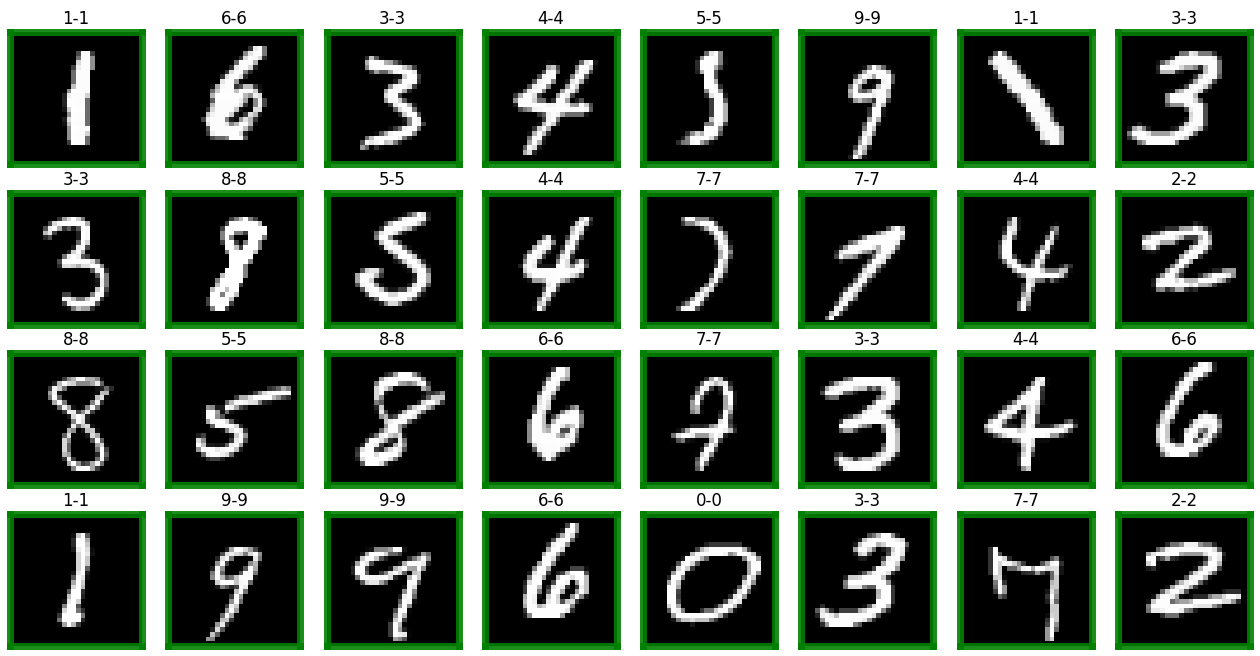

In [6]:
ckpt = result.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    loaded_model = build_resnet18()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    loaded_model.load_state_dict(state_dict)
    loaded_model.eval()
dataset = get_mnist_dataset(False)

batch_no = 4

eval_model(batch_no, loaded_model, dataset)

                             